<a href="https://colab.research.google.com/github/RudyVenguswamy/SpaceForceDataSearch/blob/main/PythonColabTutorial_Merced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on Using SpaceForceDatasearch Repo
In this tutorial you'll see: 
- The commands to train an SSL model
-Load the SSL model, to run your own custom inference script
-Load the SSL model, to run your own dataset for inference with the DALI pipeline
-The command to train a finetuner model based on your previously trained SSL Model
-Running custom and DALI inference on the trained model



In [1]:
#installs
!pip install -q split-folders
!pip install -q pytorch-lightning-bolts==0.3.0
!pip install -q --extra-index-url https://developer.download.nvidia.com/compute/redist nvidia-dali-cuda100
!pip install -q wandb

#download data
!gdown http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip -qq UCMerced_LandUse.zip

     |████████████████████████████████| 256kB 7.9MB/s 
     |████████████████████████████████| 696kB 23.0MB/s 
     |████████████████████████████████| 102kB 13.4MB/s 
     |████████████████████████████████| 276kB 36.0MB/s 
     |████████████████████████████████| 1.3MB 57.3MB/s 
     |████████████████████████████████| 143kB 57.8MB/s 
     |████████████████████████████████| 296kB 54.6MB/s 
ERROR: pytorch-lightning 1.1.6 has requirement future>=0.17.1, but you'll have future 0.16.0 which is incompatible.
     |████████████████████████████████| 387.9MB 45kB/s 
     |████████████████████████████████| 1.9MB 8.6MB/s 
     |████████████████████████████████| 133kB 59.8MB/s 
     |████████████████████████████████| 163kB 36.8MB/s 
     |████████████████████████████████| 102kB 11.3MB/s 
     |████████████████████████████████| 102kB 13.9MB/s 
     |████████████████████████████████| 71kB 11.4MB/s 
Downloading...
From: http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
To: /content/UCMer

In [2]:
import os
import itertools
import shutil
import PIL
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm.notebook import tqdm
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import PIL.Image as Image
import time
#not logging on wandb in this demo
os.environ['WANDB_MODE']='disabled'

In [3]:
!rm -rf SpaceForceDataSearch/
!git clone https://github.com/RudyVenguswamy/SpaceForceDataSearch.git

Cloning into 'SpaceForceDataSearch'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 1797 (delta 3), reused 4 (delta 1), pack-reused 1786
Receiving objects: 100% (1797/1797), 11.56 MiB | 42.42 MiB/s, done.
Resolving deltas: 100% (1152/1152), done.


In [4]:
#training SSL model with command line
!python /content/SpaceForceDataSearch/ssl_dali_distrib.py --DATA_PATH /content/UCMerced_LandUse/Images --encoder minicnn32  --num_workers 2 --log_name ssl --epochs 5 --batch_size 32

Automatically splitting data into train and validation data...
Copying files: 2100 files [00:00, 2134.95 files/s]
LOAD ENCODER:  minicnn32
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
read 1680 files from 21 directories
read 1680 files from 21 directories
read 1680 files from 21 directories
read 1680 files from 21 directories
read 420 files from 21 directories
read 420 files from 21 directories
read 420 files from 21 directories
read 420 files from 21 directories

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | miniCNN    | 128 K 
1 | projection | Projection | 20.9 K
------------------------------------------
149 K     Trainable params
0         Non-trainable params
149 K     Total params
Validation sanity check:   0% 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is 

In [5]:
#load model for custom inference script below
%cd SpaceForceDataSearch
from ssl_dali_distrib import SIMCLR
model = SIMCLR.load_from_checkpoint('/content/models/SSL/SIMCLR_SSL_ssl.ckpt')
model.eval()
model.cuda()
%cd /content      

/content/SpaceForceDataSearch
/content


torch.Size([1, 32])


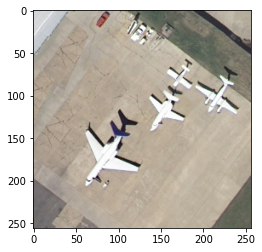

In [6]:
#custom inference script

f = "/content/UCMerced_LandUse/Images/airplane/airplane00.tif"
im = Image.open(f).convert('RGB')
plt.imshow(im)
image = np.transpose(im, (2,0,1)).copy()
im = torch.tensor(image).unsqueeze(0).float().cuda()
#get model embedding
print(model.encoder(im)[0].shape)

Below we will use the built in DALI pipeline to do inference quickly on a large number of datapoints

In [7]:
%cd SpaceForceDataSearch
#notice how we specify the folder containing the images we'd like to run inference on
model = SIMCLR.load_from_checkpoint('/content/models/SSL/SIMCLR_SSL_ssl.ckpt', DATA_PATH  = '/content/UCMerced_LandUse/Images')
%cd /content      

/content/SpaceForceDataSearch
/content


In [8]:
model.local_rank = 0
model.setup(stage = 'inference') #we set up inference with this call to instantiate the DALI data pipeline
model.eval()
model.cuda()

for batch in model.inference_dataloader():
    print(len(batch))
    print(batch[0].shape)
    break

Running model in inference mode. Dali iterator will flow data, no labels
3
torch.Size([32, 3, 256, 256])


# Fine Tuning Model

In [9]:
!python /content/SpaceForceDataSearch/finetuner_dali_distrib.py --DATA_PATH /content/split_data_SIMCLR_SSL_ssl --encoder minicnn32  --num_workers 2 --log_name ft --epochs 5 --image_size 256

LOAD ENCODER:  minicnn32
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
read 1680 files from 21 directories
read 420 files from 21 directories

  | Name         | Type         | Params
----------------------------------------------
0 | encoder      | miniCNN      | 128 K 
1 | train_acc    | Accuracy     | 0     
2 | val_acc      | Accuracy     | 0     
3 | linear_layer | SSLEvaluator | 7.1 K 
----------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
Validation sanity check:   0% 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
Epoch 0: 100% 16/

In [10]:
%cd SpaceForceDataSearch
from finetuner_dali_distrib import finetuner
model = finetuner.load_from_checkpoint('/content/models/FineTune/FineTune_ft.ckpt')
%cd /content      

/content/SpaceForceDataSearch
/content


In [11]:
model.eval()
model.cuda()

preds = []
labels = []
dirs = os.listdir('/content/UCMerced_LandUse/Images')
dirs.sort()

files = []
for i, j in enumerate(dirs):
  for f in os.listdir(f'/content/UCMerced_LandUse/Images/{j}'):
    files.append(f'/content/UCMerced_LandUse/Images/{j}/{f}')
    labels.append(i)


for f in files:
  im = Image.open(f).convert('RGB')
  image = np.transpose(im, (2,0,1)).copy()
  im = torch.tensor(image).unsqueeze(0).float()
  im = im.cuda()

  with torch.no_grad():
      probs = model(im)
      result = torch.argmax(probs, dim = 1)[0].detach().cpu().item()
      preds.append(result)

print('Accuracy:')
sum(np.array(preds) == np.array(labels))/len(np.array(preds))

Accuracy:


0.19952380952380952

In [12]:
#Now the Dali Pipeline Version

In [13]:
%cd SpaceForceDataSearch
from finetuner_dali_distrib import finetuner
model = finetuner.load_from_checkpoint('/content/models/FineTune/FineTune_ft.ckpt', DATA_PATH = '/content/UCMerced_LandUse/Images', batch_size = 128)
%cd /content      

/content/SpaceForceDataSearch
/content


In [14]:
model.local_rank = 0
model.setup(stage = 'inference')
model.eval()
model.cuda()

for batch in model.inference_dataloader():
  print(model(batch).shape)
  break

Running model in inference mode. Dali iterator will flow data, no labels
torch.Size([128, 21])


In [15]:
#This inference pipeline scales quite nicely to large datasets
num_datapoints = 100000
batch_size = 128

start = time.time()

for i in range(num_datapoints//batch_size):
  data = next(model.inference_dataloader())
  batch_predictions = model(data)

print('Time Taken: ', time.time()-start)

Time Taken:  33.05223035812378
